# **Выводы в конце ноутбука:** Backprop своими руками

Материалы:

* [Andrew Karpahy: yes, you should understand backprop](https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b)
* [Stanford CS231n](http://cs231n.stanford.edu/)
* [Deep Learning](http://sereja.me/f/deep_learning_goodfellow.pdf) — с 204 страницы и до прозрения
* [Xavier, Bengio](http://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf)

<img width='800px' src='https://cdn-images-1.medium.com/max/1600/1*q1M7LGiDTirwU-4LcFq7_Q.png'>

Иногда сети пишут на чистом C++, причём код для обучения и инференса (реального прогона в продакшне) — отдельно. Так делают, когда нужен очень быстрый отклик и высокая производительность, но это очень трудоемко.

Большинство людей не усложняют себе жизнь и просто используют фреймворки — с ними можно просто почти декларативно описать, какие операции хотите сделать с данными, а он потом сам построит сеть и подгонит её под данные.

Ваше задание — реализовать свой небольшой фреймворк глубокого обучения на чистом `numpy`. Основное время у вас должно уйти на вывод формул для градиентов, анализ поведения самых часто используемых слоев в современных нейросетях и прочий матан. Хотя бы один раз в жизни это надо сделать, а уже потом пользоваться готовыми абстракциями.

Предполагаемый порядок выполнения:
* Поймите на высоком уровне, как работает алгоритм backpropagation
* Изучите пример с логиситической регрессией, чтобы понять, что от вас в итоге хотят
* Изучите код `Module`
* `Sequential`
* `Linear`
* `SoftMax`
* `CrossEntropy`
* Протестируйте их на логситической регрессии
* Напишите код для решения MNIST
* Дописывайте остальные слои, пока не получите на нём 97%

Оценивание (суммарно до 20 баллов):
* 5 баллов -- что-то хоть как-то обучается, MNIST на валидации >90%
* 2 балла -- MNIST на 95%, дальше по одному баллу за 96%, 97% и 98%. Это будет сделать намного сложнее, чем через PyTorch, потому что вам всё нужно писать самим: более сложные оптимизаторы, learning rate decay, думать про численную стабильность и т. д.
* По 2 балла за слои: LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax

Советы:
* Чтобы лучше понять, что должно в итоге получиться, изучите «игрушечный пример» и вообще эту тетрадку, а потом начните читать `hw_framework.py`, где будет более техничное описание.
* Для дебага проверяйте градиенты численно — сдвигайте параметры на какой-нибудь эпсилон и смотрите разницу. Ещё можете проверить, что на одинаковых данных они дают то же, что их эквиваленты из PyTorch (можно после каждого нового слоя добавить юнит тест через `assert`).
* Пишите код без циклов — в питоне они очень долгие; все вычисления можно делать внутри numpy.
* Ограничение на срок сдачи большое — до конца всего курса, но рекомендуется закончить примерно за месяц. Дописывайте его постепенно, разбираясь, как работает каждая функция активации.
* Обсуждайте математику и общую архитектуру фреймворка, но не шарьте друг другу код — так не интересно.

In [ ]:
# установка модуля в vscode python
# py -3 -m venv .venv
# .venv\scripts\activate
# python -m pip install matplotlib
# deactivate

# быстрый способ
# E:/Users/vsmel/AppData/Local/Programs/Python/Python39/python.exe -m pip install matplotlib

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

---

Откройте в Jupyter две тетрадки — эту и `hw_framework.ipynb`. В этой содержится train loop, а там непосредственно ваш «фреймворк», который вам ещё предстоит написать.

Архитектура фреймворка вдохновлена PyTorch. Как всегда, если придумаете какой-то более клёвый дизайн — можете использовать его.

In [ ]:
%run hw_framework.ipynb

Wall time: 315 ms
Wall time: 27 ms
[ 1.    2.   -0.15  4.   -0.35]
[1.   1.   0.05 1.   0.05]
tensor([ 1.0000,  2.0000, -0.1500,  4.0000, -0.3500], dtype=torch.float64)
My forward:
 [7.31058579e-01 8.80797078e-01 4.74258732e-02 9.82013790e-01
 9.11051194e-04]
My backward:
 [0.19661193 0.10499359 0.04517666 0.01766271 0.00091022]
Torch forward:
 tensor([7.3106e-01, 8.8080e-01, 4.7426e-02, 9.8201e-01, 9.1105e-04],
       dtype=torch.float64)
My forward:
 [[0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]
 [0.01165623 0.03168492 0.08612854 0.23412166 0.63640865]]
My backward:
 [[ -4.44028534  -8.84051329 -13.09743907 -16.87127964 -19.07766461]
 [ -4.44028534  -8.84051329 -13.09743907 -16.87127964 -19.07766461]]
Torch forward:
 tensor([[0.0117, 0.0317, 0.0861, 0.2341, 0.6364],
        [0.0117, 0.0317, 0.0861, 0.2341, 0.6364]], dtype=torch.float64,
       grad_fn=<SoftmaxBackward0>)
Torch backword:
 tensor([[-2.5882e-18, -7.0355e-18, -1.9124e-17, -5.1985e-17, -1.4131e-16],
        [-

C:\Users\vsmel\AppData\Local\Temp/ipykernel_22424/2627669197.py:21: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  torch_ans = torch_layer(x_tensor)


Мы будем использовать самый простой вариант градиентного спуска: просто пройдемся по всем параметрам и сделаем шаги в сторону уменьшения посчитанного заранее градиента.

Есть [более продвинутые методы](http://ruder.io/optimizing-gradient-descent/), но пока что мы их использовать не будем.

In [ ]:
def SGD(params, gradients, lr=1e-3):  # Stochastic gradient descent
    for weights, gradient in zip(params, gradients):
        #print(type(lr), type(gradient))
        #print(lr, gradient)
        weights -= lr * gradient

Cоздадим обертку вокруг нашего датасета (просто numpy-евские массивы), которую будем потом использовать, чтобы итерироваться по нему.

In [ ]:
def loader(X, Y, batch_size):    
    n = X.shape[0]

    # в начале каждой эпохи будем всё перемешивать
    # важно, что мы пермешиваем индексы, а не X
    indices = np.arange(n)
    np.random.shuffle(indices)
    
    for start in range(0, n, batch_size):
        # в конце нам, возможно, нужно взять неполный батч
        end = min(start + batch_size, n)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

В следующих двух секциях — игрушечные примеры регрессии и классификации на синтезированных данных. В них ничего менять не надо — они нужны, чтобы отдебажить ваши слои в `hw_framework`.

# Линейная регрессия

In [ ]:
# y = x W + eps (n x 10  10 x 1 = n x 1)

n = 1000

X = np.random.randn(n, 10)
true_w = np.random.randn(10, 1)
# без шума
# Y = np.dot(X, true_w).reshape(n, 1)
# c шумом точность ниже
Y = (np.dot(X, true_w).reshape(n, 1) + np.random.randn(n, 1)/5)
print('best_possible_mse:', np.mean(np.power(Y-np.dot(X, true_w).reshape(n), 2)))

best_possible_mse: 11.920773756993647


### Модель

In [ ]:
# model и criterion разделяем т. к. хотим получать выходы чтобы считать точность и др характеристики между слоями
# c точки зрения оптимизации один и тот же вычислительный граф
model = Sequential(
    Linear(10, 8),
    #Sigmoid(),
    #ReLU(),
    Linear(8, 1),
)
criterion = MSE()

Можете тут потом тестировать остальные свои слои, когда их напишите.

### Обучение

In [ ]:
epochs = 10
batch_size = 10
learning_rate = 1e-1

In [ ]:
%run hw_framework.ipynb

epoch 0 | 0.21049163822154263
epoch 1 | 0.07839325607603817
epoch 2 | 0.04240207142622156
epoch 3 | 0.03599330702930449
epoch 4 | 0.10944286348214456
epoch 5 | 0.1546329856776614
epoch 6 | 0.037776862167616915
epoch 7 | 0.02880293780978111
epoch 8 | 0.14247711546370576
epoch 9 | 0.02652841442024293


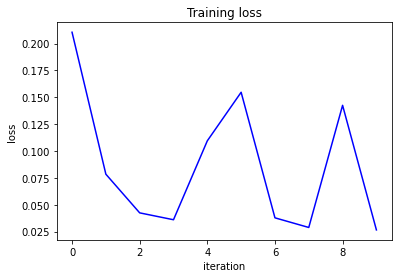

In [ ]:
# каждый раз создаем модель, чтобы обновлять веса, которые получили при трейне прошлой модели
model = Sequential(
    Linear(10, 4),
    #ReLU(),
    LeakyReLU(),
    #Sigmoid(),
    Linear(4, 1),
)
criterion = MSE()

history = []
# !! lr потихоньку изменять во время обучения для лучшей точности попробовать
for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward -- считаем все значения до функции потерь
        y_pred = model.forward(x)
        y_true = y_true.reshape(batch_size, -1) # -1 догадайся сам
        loss = criterion.forward(y_pred, y_true)
        
        #print(y_pred, y_true)
        #print('SUM OF SQUARES:', np.mean(np.power(y_pred-y_true, 2)))
    
        # backward -- считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true) # у критерия нет градиентов
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
        #print(model.layers[0].W[0][0])
        #print("epoch"loss)
        
    history.append(loss)

    print(f"epoch {i} |", loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

# Логистическая регрессия

Этот пример нужнен для теситрования классификации (`CrossEntropy` и `SoftMax`).

Возьмем в качестве датасета точки из двух гауссиан на плоскости.

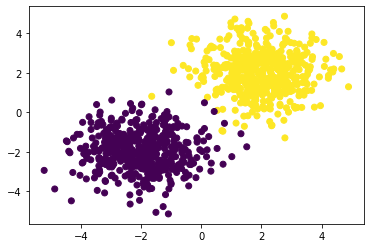

In [ ]:
# логистическая регресия = Linear + softmax
n = 500

X1 = np.random.randn(n, 2) + np.array([2, 2])
X2 = np.random.randn(n, 2) + np.array([-2, -2])
X = np.vstack([X1, X2])

Y = np.concatenate([np.ones(n), np.zeros(n)])[:, None]
Y = np.hstack([Y, 1-Y])

plt.scatter(X[:,0], X[:,1], c=Y[:,0])
plt.show()

Обратите внимание на `y`. Он в формате one-hot: у каждого вектора все нули, кроме одной единицы.

Выходные данные в таком формате упростят написание `CrossEntropy`.

### Модель

Логистическая регрессия — это тоже как бы маленькая нейронка: линейный слой, софтмакс, и максимизируем правдоподобие.

In [ ]:
model = Sequential(
    Linear(2, 2),
    SoftMax()
)

criterion = CrossEntropy()

### Обучение

In [ ]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

In [ ]:
%run hw_framework.ipynb

epoch 0 | 0.5891377574844715
epoch 1 | 0.5869437347593143
epoch 2 | 0.6035324384801839
epoch 3 | 0.5822848986020549
epoch 4 | 0.6034126549947766
epoch 5 | 0.588985171857992
epoch 6 | 0.5844407403318757
epoch 7 | 0.5804982668244842
epoch 8 | 0.6028250931182261
epoch 9 | 0.5910547550037345


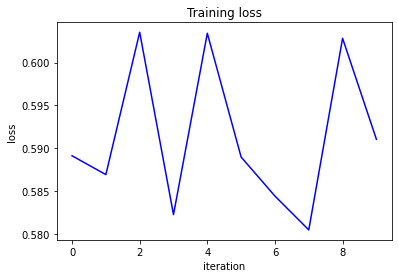

In [ ]:
epochs = 10
batch_size = 16
learning_rate = 1e-2

# каждый раз создаем модель, чтобы обновлять веса, которые получили при трейне прошлой модели
model = Sequential(
    Linear(2, 10),
    Sigmoid(),
    Linear(10, 2),
    SoftMax()
)

criterion = CrossEntropy()

history = []

for i in range(epochs):
    for x, y_true in loader(X, Y, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        
    # логгируем лосс
    history.append(loss)
    print(f"epoch {i} |", loss)

    
plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

Мы тут пропустили много важных деталей: валидация, подсчет точности (кроссэнтропия не очень информативна), регуляризация. Вам всё это нужно будет реализовать потом самим.

# MNIST selfnet

In [ ]:
import os
import pandas
from sklearn.datasets import fetch_openml
# эти библиотеки нужны только для того, чтобы скачать MNIST
import tempfile
test_data_home = tempfile.mkdtemp()

if os.path.exists('mni st.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_openml('mnist_784')
    # очень важно его отнормировать -- см. Linear в hw_framework
    X = mnist.data / 255.0
    y = mnist.target
    np.savez('mnist.npz', X=X, y=y)

Переведите лейблы в one-hot.

In [ ]:
def one_hot_encoding(y):
    res = []
    sample_len = 10
    for elem in y:
        temp = list(np.zeros(sample_len, dtype=float))
        temp[int(elem)] = 1.
        res.append(temp)
    return np.array(res)


In [ ]:
y

In [ ]:
y0 = one_hot_encoding(y)

In [ ]:
y0

In [ ]:
X = np.array(X)

Разделите датасет на train и test.

In [ ]:
def train_test_split(X, y, test_size=0.20, random_state=42):
    max_len = len(y)
    split_len = int((1-test_size)*max_len)
    return X[:split_len], X[split_len:], y[:split_len], y[split_len:]

In [ ]:
data_train, data_test, labels_train, labels_test = train_test_split(
    X, y0, test_size=0.10, random_state=42)


In [ ]:
print("data_train.shape:", data_train.shape)
print("data_test.shape:", data_test.shape)
print("labels_train.shape:", labels_train.shape)
print("labels_test.shape:", labels_test.shape)


data_train.shape: (63000, 784)
data_test.shape: (7000, 784)
labels_train.shape: (63000, 10)
labels_test.shape: (7000, 10)


Теперь напишите модель и train loop. Можете начать с адаптации предыдущего примера.

Дальше начинается творческая часть и настоящий Deep Learning:
* поиграйтесь с архитектурами;
* поиграйтесь с learning rate и batch_size;
* сделайте learning rate decay;
* сделайте data augmentation.

Have fun. Дедлайн — не две недели, а до конца курса.

In [ ]:
%run hw_framework.ipynb


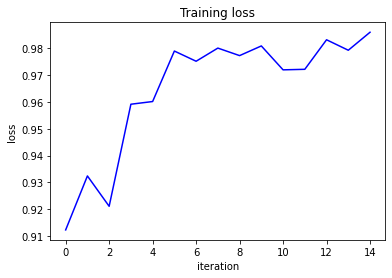

In [ ]:
epochs = 15
batch_size = 16
learning_rate = 1e-2

# каждый раз создаем модель, чтобы обновлять веса, которые получили при трейне прошлой модели
model = Sequential(
    Linear(784, 800),
    LeakyReLU(),
    Linear(800, 400),
    LeakyReLU(),
    Linear(400, 10),
    SoftMax()
)
criterion = CrossEntropy()
#model.train()

history = []

for i in range(epochs):
    for x, y_true in loader(data_train, labels_train, batch_size):
        # forward: считаем все значения до функции потерь
        y_pred = model.forward(x)
        loss = criterion.forward(y_pred, y_true)
        print(y_pred)
    
        # backward: считаем все градиенты в обратном порядке
        grad = criterion.backward(y_pred, y_true)
        model.backward(x, grad)
        
        # обновляем веса
        SGD(model.parameters(),
            model.grad_parameters(),
            learning_rate)
        learning_rate *=0.98
        
        # логгируем лосс
        history.append(loss)
        #print(f"epoch {i+1} |", loss)

plt.title("Training loss")
plt.xlabel("iteration")
plt.ylabel("loss")
plt.plot(history, 'b')
plt.show()

In [ ]:
#model.eval()

test_len = labels_test.shape[0]
count_true = 0
for x, y_true in loader(data_test, labels_test, 1):

    y_pred = list(model.forward(x))
    y_true = list(y_true)
    y_pred = list(y_pred[0])
    y_true = list(y_true[0])
    #print(y_pred, y_true)

    max_ind = y_pred.index(max(y_pred))
    y_true = y_true.index(max(y_true))

    if (max_ind == y_true):
        count_true += 1
    
    #print(max_ind, y_true)
    
    

acc = count_true/test_len
print("Точность на тестовой выборке: {:.2%}".format(acc))


Точность на тестовой выборке: 98.19%


# Выводы:
Для MNIST

Удалось добиться точности на тестовой выборке 98.19% с относительно базовой архитектурой сети (линейные слои, LeakyReLU, SoftMax).

Реализовал слои LeakyReLU, Dropout, BatchNorm, CrossEntropy, SoftMax во втором ноутбуке hw_framework.ipynb.